<a href="https://colab.research.google.com/github/yschimpf/feedback_alignment/blob/main/documented_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np

In [87]:
class NeuralNetwork(object):
  """
  Neural Network class that allows to create, train and evaluate a Neural Network
  for different regression and classification.

  Attributes
  ----------
  layers : list
  activations : list
  loss : {'MSE','LCE'}
  mode : {'BP', 'FA'}
  weights : numpy.ndarray
    Forward weights for both modes and also backward weights for BP
  feedbackweights : numpy.ndarray
    Backward weights for mode FA
  biases : numpy.ndarray
  errors : list
    Used for error plotting
  """


  def __init__(self, layers = [2,10,1], activations = ['sigmoid','identity'], loss = 'MSE', mode = 'BP'):
    """
    Constructor to create a new network with selected paramters

    Parameters
    ----------
    self : NeuralNetwork
    layers : list
      defines the number of units per unit
    activations : list
      defines the activation functions for units starting with first hidden layer.
      For regression the last layer should have the identity, for classification
      it should be softmax. Can be one of {'sigmoid', 'identity', 'relu', 'softmax'}
    loss : {'MSE', 'LCE'}
      Select either Mean Squared Error or Cross Entropy Loss
    mode = {'BP', 'FA'}
      Select eitehr Backpropagation or Feedback alignment
    """
    assert(len(layers) == len(activations)+1)
    self.layers = layers
    self.activations = activations
    self.feedbackweights = []
    self.loss = loss
    self.weights = []
    self.biases = []
    self.errors = []
    self.mode = mode

    #Random weight & bias initialization
    for i in range (len(layers)-1):
      self.weights.append(np.random.randn(layers[i+1], layers[i]))
      self.feedbackweights.append(np.random.randn(layers[i+1], layers[i]))
      self.biases.append(np.random.randn(layers[i+1], 1))


  def feedforward(self, x):
    """
    Forward pass of the neural network.

    Parameters
    ----------
    self : NeuralNetwork
    x : numpy.ndarray
    """
    #initialize for first layer
    v = np.copy(x)
    z_s = []
    v_s = [v]
    for i in range(len(self.weights)):
      #for all other layers apply weights and then the activation
      activation = self.getActivationFunction(self.activations[i])
      z_s.append(self.weights[i].dot(v)+self.biases[i])
      v = activation(z_s[-1])
      v_s.append(v)
    return (z_s, v_s)


  def backpropagation(self, y, z_s, v_s):
    """
    Backward pass for the NeuralNetwork. Applies either the Backproagation or the
    Feedback Alignment algorithm depending on class initialization

    Parameters
    ----------
    self : NeuralNetwork
    y : numpy.ndarray
    z_s : numpy.ndarray
      Inputs of units per layer.
    v_s : numpy.ndarray
      Outputs of units per layer i.e. the activated weigthed inputs.
    """

    #derivatives of Loss w.r.t the weights per layer
    dw = []
    #derivatives of loss w.r.t. to unit inputs per layer
    deltas = [None]*len(self.weights)

    #delta for las layer
    deltas[-1] = (self.getDerivativeLoss(self.loss)(v_s[-1], y))

    #backpropagation
    if(self.mode=='BP'):
      for i in reversed(range(len(deltas)-1)):
        deltas[i] = self.weights[i+1].T.dot(deltas[i+1])*(self.getDerivativeActivation(self.activations[i])(z_s[i]))
      batch_size = y.shape[1]
      #weight updates
      dw = [d.dot(v_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]
      #bias updates
      db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for i,d in enumerate(deltas)]

    #feedback alignment
    elif(self.mode == 'FA'):
      for i in reversed(range(len(deltas)-1)):
        deltas[i] = self.feedbackweights[i+1].T.dot(deltas[i+1])*(self.getDerivativeActivation(self.activations[i])(z_s[i]))
      batch_size = y.shape[1]
      #cweight updates
      dw = [d.dot(v_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]
      #bias updates
      db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for i,d in enumerate(deltas)]
    return dw, db


  def train(self, x, y, batch_size=10, epochs=100, lr = 0.01):
    """
    Trains the network i.e. compute forward pass and find updates in backward pass.

    Paramerters
    -----------
    self : NeuralNetwork
    x : numpy.ndarray
    y : numpy.ndarray
    batch_size : int
    epochs : int
    lr : float
    """
    for e in range (epochs):
      i = 0
      while(i < len(y)):
        x_batch = x[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        i = i+batch_size
        #compute forward pass
        z_s, v_s = self.feedforward(x_batch)
        #compute backward pass
        dw, db = self.backpropagation(y_batch, z_s, v_s)
        #update weights
        self.weights = [w - lr*dweight for w,dweight in zip(self.weights, dw)]
        #update biases
        self.biases = [b - lr*dbias for b,dbias in zip(self.biases, db)]
      self.errors.append(self.getLoss(self.loss)(v_s[-1],y_batch))


  def predict(self, X):
    """
    Computes the predictions of the network for a particular input in
    case of classification.

    Parameter
    ---------
    self : NeuralNetwork
    X : numpy.ndarray
    """
    #compute forward pass
    _, f = self.feedforward(X)
    #predict argmax
    pred = np.argmax(f[-1], axis=0)
    return pred


  @staticmethod
  def getActivationFunction(name):
    """
    Definition of nonlinearities

    Parameter
    ---------
    name : {'sigmoid', 'identity', 'relu', 'softmax'}
    """
    if(name == 'sigmoid'):
      return lambda x : np.exp(x)/(1+np.exp(x))
    elif(name == 'identity'):
      return lambda x : x
    elif(name == 'relu'):
      def relu(x):
        y = np.copy(x)
        if(y<0):
          return 0
        else:
          return y
      return relu
    elif(name == 'softmax'):
      def softmax(x):
        #numerically stable computation of softmax
        e_x = np.exp(x-np.max(x))
        return e_x/e_x.sum(axis=1, keepdims = True)
      return softmax
    else:
      print('Unknown activation function. Identity is used')
      return lambda x:x


  @staticmethod
  def getDerivativeActivation(name):
    """
    Derivatives of activation functions

    Parameter
    ---------
    name : {'sigmoid', 'identity', 'relu', 'softmax'}
    """
    if(name == 'sigmoid'):
      sigmoid = lambda x : np.exp(x)/(1+np.exp(x))
      return lambda x : sigmoid(x)*(1-sigmoid(x))
    elif(name == 'identity'):
      return lambda x : 1
    elif(name == 'relu'):
      def drelu(x):
        y = np.copy(x)
        if(y >= 0): y = 1
        else: y = 0
        return y
      return drelu
    elif(name == 'softmax'):
      print('In this code access to softmax derivatives should not be required via this function please redefine your network. Please redefine your network. Identity was used instead.')
      return exit()
    else:
      print('Unknown activation, identity was used instead')
      return lambda x : 1


  @staticmethod
  def getLoss(name):
    """
    Definitions of loss functions

    Parameter
    ---------
    name : {'MSE', 'LCE'}
    """
    if(name == 'MSE'):
      return lambda f, y : np.linalg.norm(f-y)
    elif(name == 'LCE'):
      return lambda f, y : -(y*np.log(f)).sum()
    else:
      print('Unknown loss, cannot make useful computations')
      exit()


  @staticmethod
  def getDerivativeLoss(name):
    """
    Computes the ferivative of the last layer w.r.t. to the loss

    Parameter
    ---------
    name = {'MSE','LCE'}
    """
    if(name == 'MSE'):
      return lambda f, y : (f-y)
    elif(name == 'LCE'):
      return lambda f, y : (f-y)
    else:
      print('Unknown loss, cannot make useful computations')
      exit()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'int'>
<class 'int'>
<class 'float'>
loss =45.18534700605397
loss =8.852549545312733
loss =5.025335396999647
loss =3.653406607020866
loss =3.3612659738477513
loss =3.265211173391857
loss =3.200285923813388
loss =3.1427796231293867
loss =3.0890960883435024
loss =3.0385221265857374
loss =2.9908443500273
loss =2.945962534631174
loss =2.9037995918550314
loss =2.864272328489611
loss =2.82728265933052
loss =2.7927180404171867
loss =2.760455980156239
loss =2.7303698496445783
loss =2.7023345863342874
loss =2.676231741076558
loss =2.6519538332422323
loss =2.6294082824366605
loss =2.608521387017738
loss =2.589243012559454
loss =2.571552931590457
loss =2.555470244285549
loss =2.541068220072329
loss =2.528498644099953
loss =2.5180331884205427
loss =2.5101363192175605
loss =2.505598934326694
loss =2.505793320408266
loss =2.513175043839045
loss =2.5322635867926797
loss =2.571268995900677
loss =2.6425133909061453
loss =2.7498056217859967
loss =2.

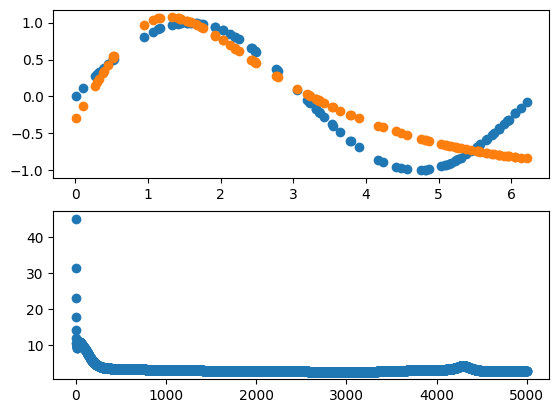

In [88]:
#first testrun
import matplotlib.pyplot as plt
nn = NeuralNetwork([1,20,100,1], activations = ['sigmoid','sigmoid','identity'], loss = 'MSE', mode = 'BP')
X = 2 * np.pi * np.random.rand(100).reshape(1,-1)
y = np.sin(X)
#print(X.shape)
#print(y.shape)
#print(X)
n_epoch = 5000
#nn.train(X,y,epochs=n_epoch,batch_size = 64, lr = 0.1)
#_,v_s_bp= nn.feedforward(X)

nn_ = NeuralNetwork([1,20,100,1], activations = ['sigmoid','sigmoid','identity'], loss = 'MSE', mode = 'FA')
nn_.train(X,y,epochs=n_epoch,batch_size = 64, lr = 0.01)
_,v_s_fa= nn_.feedforward(X)
#print(y,X)
fig, ax = plt.subplots(2)
ax[0].scatter(X.flatten(), y.flatten())
#ax[0].scatter(X.flatten(),v_s_bp[-1].flatten())
ax[0].scatter(X.flatten(),v_s_fa[-1].flatten())
#ax[1].scatter(np.arange(n_epoch).flatten(),nn.errors)
ax[1].scatter(np.arange(n_epoch).flatten(),nn_.errors)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


loss =3266.7615807645097
loss =3191.3953890102894
loss =3201.4686170161212
loss =3253.0609281821335
loss =3321.9038967466204
loss =3307.361024807204
loss =3291.550410145216
loss =3263.179329756737
loss =3253.1461908048122
loss =3320.5716662669774
loss =3418.7797332117425
loss =3485.4164726834274
loss =3529.5455049554885
loss =3602.0061489578216
loss =3686.9940984746872
loss =3772.3545220668907
loss =3854.7425271245847
loss =3934.0082042683493
loss =4014.4400495938094
loss =4101.596075153788
loss =4184.1241431998715
loss =4245.591227309367
loss =4285.561058241838
loss =4306.2513340015685
loss =4306.805299426942
loss =4286.852348581517
loss =4250.368447529082
loss =4207.229356208865
loss =4169.48348516728
loss =4144.516634763922
loss =4132.546254666405
loss =4129.098620970773
loss =4127.380245951562
loss =4119.81911820187
loss =4132.868265909561
loss =4692.042562649884
loss =4564.776160856385
loss =4031.679828034049
loss =4161.440729594873
loss =4275.12453911223
loss =4365.501357514952
l

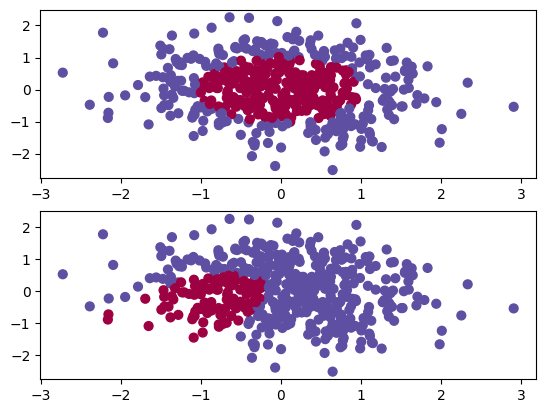

In [84]:
import sklearn.datasets
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

def load_extra_datasets():
    N = 500
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.7, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    return  gaussian_quantiles
gaussian_quantiles= load_extra_datasets()
X, Y = gaussian_quantiles
y = []
X, Y = X.T, Y.reshape(1, Y.shape[0])
Y = Y.reshape(-1, 1)

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform Y to one-hot encoding
Y_onehot = encoder.fit_transform(Y)
# Visualize the data
fig, ax = plt.subplots(2)
ax[0].scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
nn = NeuralNetwork([2,50,50,2], activations = ['sigmoid','sigmoid','softmax'], loss = 'LCE',mode='FA')
n_epoch = 5000
nn.train(X,Y_onehot.T,epochs=n_epoch,batch_size = 64, lr = 0.01)
pred = nn.predict(X)
#print(pred)
ax[1].scatter(X[0, :], X[1, :], c=pred.reshape(1, Y.shape[0]), s=40, cmap=plt.cm.Spectral)
#print(y,X)

In [5]:
#testing stuff
arr = np.array([1,2,3,4])
print(arr[-1])

4


In [28]:
def softmax(x):
    """ applies softmax to an input x"""
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=1, keepdims = True)

x = np.array([[1, 0, 3, 5],[1, 0, 3, 5]])
print(x.shape)
y = softmax(x)
y, x / x.sum()

(2, 4)


(array([[0.01578405, 0.00580663, 0.11662925, 0.86178007],
        [0.01578405, 0.00580663, 0.11662925, 0.86178007]]),
 array([[0.05555556, 0.        , 0.16666667, 0.27777778],
        [0.05555556, 0.        , 0.16666667, 0.27777778]]))